# Stepped solution

In [38]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [39]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()
solver = pybamm.ScikitsDaeSolver()
sim = pybamm.Simulation(model, solver=solver)

Final time 4000.0s


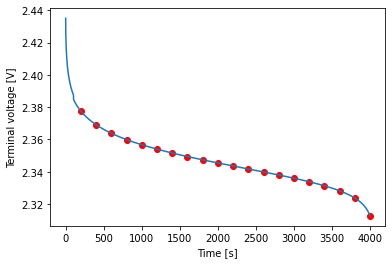

In [40]:
tstep = 200
npts = 200

error = False 

while error is False:
    try:
        solution = sim.step(tstep, npts=npts)
        t = solution.t
        V = solution["Terminal voltage [V]"].entries
        plt.plot(t[-1], V[-1], 'ro')
    except pybamm.SolverError:
        error = True
        t = solution.t
        V = solution["Terminal voltage [V]"].entries
        plt.plot(t, V)        
        plt.xlabel("Time [s]")
        plt.ylabel("Terminal voltage [V]")        
        print("Final time {}s".format(solution.t[-1]))

In [41]:
sim.plot(model.variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.1111111111111112, step=0.01111111111111111…

# Try at 1.7A (C/2) and reduce tstep after SolverError

In [42]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()

# Update current 
param = model.default_parameter_values
param.update({"Current function [A]": 1.7})

# Update current and ICs to correspond to initial 2.4V as in ref [2]
#param.update({    
#    "Initial Condition for S8 ion [g]": 2.6730,
#    "Initial Condition for S4 ion [g]": 0.0128,
#    "Initial Condition for S2 ion [g]": 4.3321e-6,
#    "Initial Condition for S ion [g]": 1.6321e-6,
#    "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
#    "Initial Condition for Terminal Voltage [V]": 2.4,
#})

# Set up solver and simulation
solver = pybamm.ScikitsDaeSolver(atol=1e-6,rtol=1e-3)
sim = pybamm.Simulation(model, parameter_values=param, solver=solver)

Final time 7171.875s
Final discharge capacity 3.386718750000004 Ah


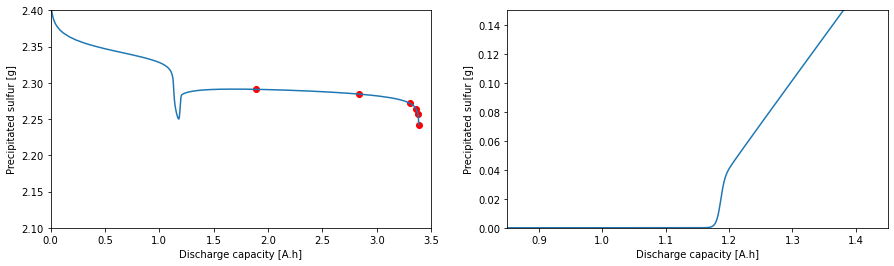

In [43]:
# set up figure 
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].set_xlim([0, 3.5])
ax[0].set_ylim([2.1, 2.4])
ax[0].set_xlabel("Discharge capacity [A.h]")
ax[0].set_ylabel("Terminal voltage [V]")
ax[1].set_xlim([0.85, 1.45])
ax[1].set_ylim([0, 0.15])
ax[1].set_xlabel("Discharge capacity [A.h]")
ax[1].set_ylabel("Precipitated sulfur [g]")

# step solution

tstep = 4000  # going to fix npts = tpts, but not sure this is necessary  
tmin = 10  # minimum step 10s 

while tstep > tmin:
    try:
        solution = sim.step(tstep, npts=int(tstep))
        DC = solution["Discharge capacity [A.h]"].entries
        V = solution["Terminal voltage [V]"].entries
        ax[0].plot(DC[-1], V[-1], 'ro')
    except pybamm.SolverError:
        tstep = tstep/2

# extract variables and plot
DC = solution["Discharge capacity [A.h]"].entries
V = solution["Terminal voltage [V]"].entries
S = solution["Precipitated Sulfur [g]"].entries

print("Final time {}s".format(solution.t[-1]))
print("Final discharge capacity {} Ah".format(DC[-1]))

ax[0].plot(DC, V)  
ax[1].plot(DC, S);  


In [44]:
solution.t[-1]

7171.875

In [45]:
sim.plot(model.variables, time_unit="seconds")

interactive(children=(FloatSlider(value=0.0, description='t', max=7171.875, step=71.71875), Output()), _dom_cl…

# Try straight solve

In [59]:
models = [
    pybamm.lithium_sulfur.MarinescuEtAl2016(),
    pybamm.lithium_sulfur.MarinescuEtAl2016(),
]

# Update current 
params = [model.default_parameter_values, model.default_parameter_values]
params[0].update({"Current function [A]": 1.7})
params[1].update({"Current function [A]": 1.7})

# Update current and ICs for second model to correspond to initial 2.4V as in ref [2]
params[1].update({    
    "Initial Condition for S8 ion [g]": 2.6730,
    "Initial Condition for S4 ion [g]": 0.0128,
    "Initial Condition for S2 ion [g]": 4.3321e-6,
    "Initial Condition for S ion [g]": 1.6321e-6,
    "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
    "Initial Condition for Terminal Voltage [V]": 2.4,
})

# Set up and solve simulations
sims = []
for i, model in enumerate(models):
    sim = pybamm.Simulation(
        model, 
        parameter_values=params[i], 
        solver=pybamm.ScikitsDaeSolver(atol=1e-6,rtol=1e-3)
    )
    sim.solve(np.linspace(0, 7125, 7125))
    sims.append(sim)

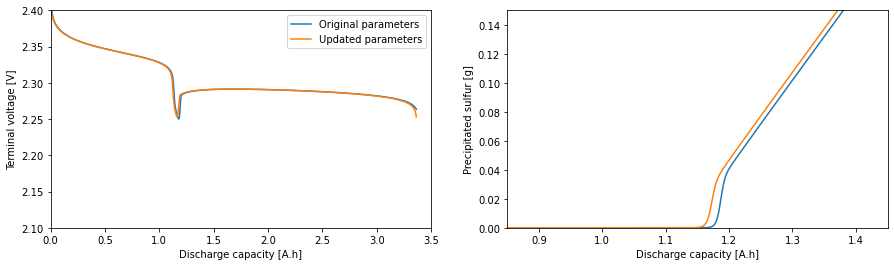

In [60]:
# set up figure 
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].set_xlim([0, 3.5])
ax[0].set_ylim([2.1, 2.4])
ax[0].set_xlabel("Discharge capacity [A.h]")
ax[0].set_ylabel("Terminal voltage [V]")
ax[1].set_xlim([0.85, 1.45])
ax[1].set_ylim([0, 0.15])
ax[1].set_xlabel("Discharge capacity [A.h]")
ax[1].set_ylabel("Precipitated sulfur [g]")

# extract variables and plot
for sim in sims:
    DC = sim.solution["Discharge capacity [A.h]"].entries
    V = sim.solution["Terminal voltage [V]"].entries
    S = sim.solution["Precipitated Sulfur [g]"].entries
    ax[0].plot(DC, V)  
    ax[1].plot(DC, S);  

ax[0].legend(["Original parameters", "Updated parameters"])